In [1]:
import logging
from allennlp.models.archival import load_archive
from allennlp.data import DatasetReader, Vocabulary
from allennlp.common.util import import_module_and_submodules, prepare_environment
import json
from pathlib import Path

RESULT_DIR = Path("results/flickr30k/show_attend_rnn_best/default")

archive_path = RESULT_DIR / "model.tar.gz"

logging.disable(logging.INFO)
import_module_and_submodules("experiments")
import_module_and_submodules("models")

archive = load_archive(archive_path, cuda_device=9)
config = archive.config
prepare_environment(config)

model = archive.model
model.beam_search = None
model.eval()

dataset_reader = DatasetReader.from_params(config.pop("dataset_reader"))

vocab = Vocabulary.from_files(RESULT_DIR / "vocabulary")

158915it [00:00, 409041.87it/s]


In [37]:
from allennlp.data import DataLoader

dataset = dataset_reader.read(config["validation_data_path"])
dataset.index_with(vocab)

data_loader = DataLoader(dataset, shuffle=True)

In [38]:
from allennlp.nn.util import move_to_device
for batch in data_loader:
    batch = move_to_device(batch, 9)
    batch.pop("target_tokens")
    output_dict = model(**batch)
    break

/home/li0123/.cache/pypoetry/virtualenvs/image-captioning-1zQvGTYG-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  del sys.path[0]


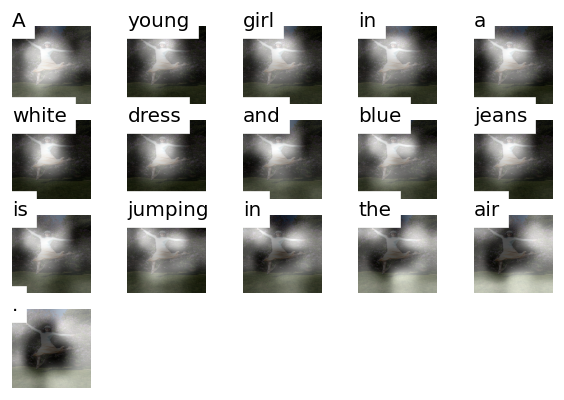

In [39]:
from image_utils import apply_mask_to_image

plt.rcParams['figure.dpi'] = 120


image_path = Path("/data/11/corpora/flickr30k/flickr30k-images") / batch['image_name'][0]
predicted_tokens = output_dict['prediction'][0]
image_per_row = 5
attention_weights = output_dict['attention_weights'][0].detach().cpu().numpy()
attention_weights = attention_weights.reshape(-1, 7, 7)

for t, word in enumerate(predicted_tokens):
    plt.subplot(np.ceil(len(predicted_tokens) / image_per_row), image_per_row, t + 1)
    apply_mask_to_image(image_path, attention_weights[t], text=word)